### Load data

In [1]:
from sklearn import datasets
import pandas as pd
pd.set_option('display.max_columns', None)
import sys
sys.path.append('../../')

diabetes = datasets.load_diabetes()
data = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
target = pd.Series(diabetes.target)
df = pd.concat([data, target], axis=1)
df.columns.values[-1] = 'target'

### Initialize a TabularMagic object

In [2]:
from tabularmagic import TabularMagic
tm = TabularMagic(df, test_size=0.2, name='Diabetes scikit-learn dataset')
tm

INFO: Initialization complete. Shapes of train, test DataFrames: (353, 11), (89, 
      11). 


Diabetes scikit-learn dataset 
--------------------------------------------------------------------------------
Train shape: (353, 11)                   Test shape: (89, 11)                   
--------------------------------------------------------------------------------
Categorical variables:
  None 
                                                                                
Continuous variables:
  age, sex, bmi, bp, s1, s2, s3, s4, s5, s6, target 

### Preprocessing

Force sex to binary (0-and-1-valued continuous) variables

In [3]:
tm.datahandler().force_binary(['sex'])

INFO: Forced variables sex to binary. Variables renamed to 
      0.05068011873981862_TRUE(sex). 


Diabetes scikit-learn dataset 
--------------------------------------------------------------------------------
Train shape: (353, 11)                   Test shape: (89, 11)                   
--------------------------------------------------------------------------------
Categorical variables:
  None 
                                                                                
Continuous variables:
  age, 0.05068011873981862_TRUE(sex), bmi, bp, s1, s2, s3, s4, s5, s6, target 

### Conduct exploratory analysis

Visualize the distribution of the target variable statified by sex

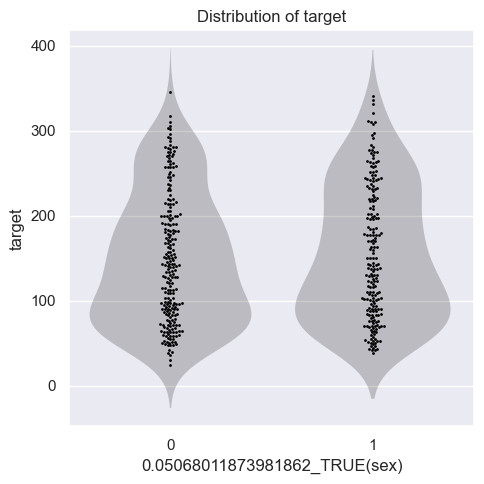

In [4]:
tm.eda(dataset='all').plot_distribution_stratified(
    'target', '0.05068011873981862_TRUE(sex)', strategy='violin_swarm')

Visualize the distribution of the target variable in relation with bmi, age, bp

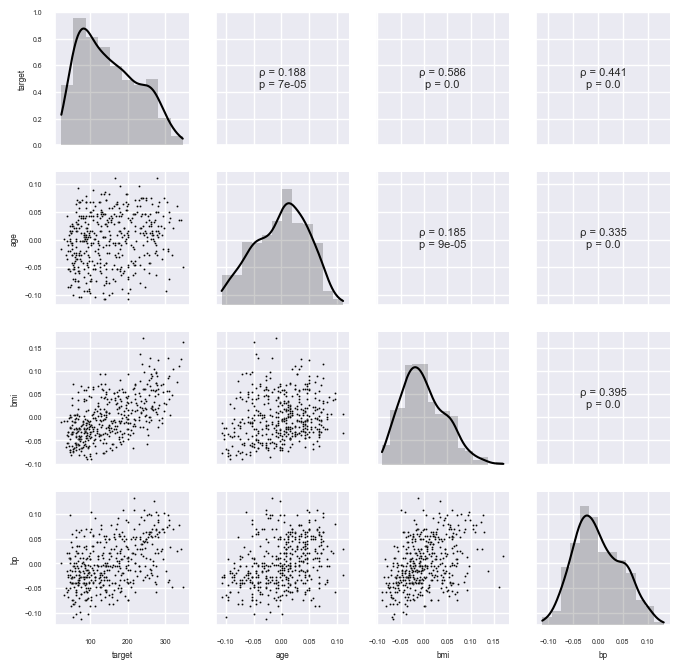

In [5]:
tm.eda(dataset='all').plot_continuous_pairs(
    continuous_vars=['target', 'age', 'bmi', 'bp']
)

### Regression analysis

In [6]:
lm_report = tm.lm(
    formula='target ~ age + bmi + bp + 0.05068011873981862_TRUE(sex) + bp:0.05068011873981862_TRUE(sex)'
)
lm_report.statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     78.41
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           7.28e-55
Time:                        00:01:48   Log-Likelihood:                -1940.0
No. Observations:                 353   AIC:                             3892.
Df Residuals:                     347   BIC:                             3915.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                              155.3958      4.605     33.746      0.000     146.370     164.421
age                                 66.5596     68.288      0.975      0.330     -67.281     200.401
bmi                                817.1307     75.365     10.842      0.000     669.417     964.844
bp                                 281.0417     95.802      2.934      0.003      93.273     468.810
0.05068011873981862_TRUE(sex)      -10.5060      6.312     -1.664      0.096     -22.878       1.866
bp:0.05068011873981862_TRUE(sex)   293.8286    124.317      2.364      0.018      50.171     537.486
==============================================================================
Omnibus:                        9.655   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                5.330
Skew:                           0.072   Prob(JB):                       0.0696
Kurtosis:                       2.415   Cond. No.                         53.3
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

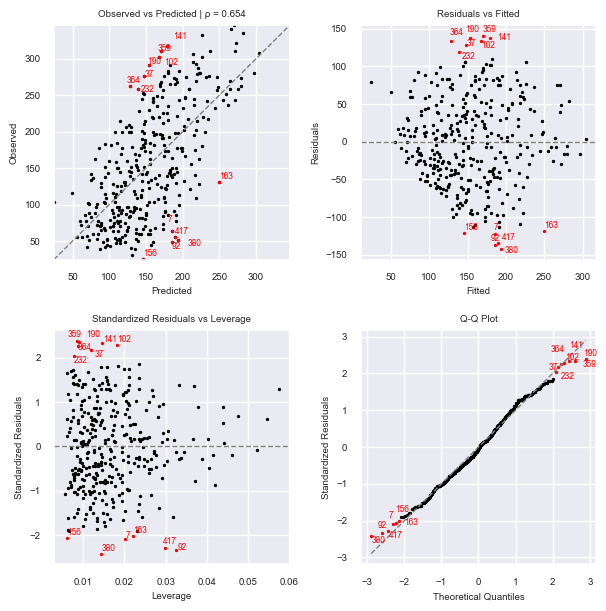

In [7]:
lm_report.train_report().set_outlier_threshold(2).plot_diagnostics(
    show_outliers=True)

In [8]:
lm_report.train_report().fit_statistics()

,OrdinaryLeastSquares_train
Statistic,
rmse,58.954531
mad,48.701527
pearsonr,0.654225
spearmanr,0.623311
r2,0.42801
adjr2,0.419768
n,353


In [9]:
lm_report.test_report().fit_statistics()

,OrdinaryLeastSquares_test
Statistic,
rmse,60.750438
mad,49.979177
pearsonr,0.561894
spearmanr,0.552851
r2,0.303415
adjr2,0.261452
n,89


### Machine learning regression benchmarking

Each model performs a grid search to find optimal estimator. Nested k-fold cross validation is performed to assess model fit on train. Models are also assesed on test.

In [22]:
from tabularmagic.ml import CustomR, LinearR
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import numpy as np


ml_report = tm.ml_regression(
    models=[
        CustomR(
            estimator=Lasso(alpha=0.1),
            name='Lasso alpha=0.1'
        ),
        CustomR(
            estimator=GridSearchCV(
                estimator=Lasso(alpha=0.5),
                param_grid={'alpha': np.logspace(-4, 4, 10)},
            ),
            name='Lasso GridSearchCV'
        ),
        LinearR('l1')
    ],
    y_var='target',
    X_vars=['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'],
    outer_cv=5,
    outer_cv_seed=0
)

INFO: Fitting model Lasso alpha=0.1. 
INFO: Fitted model Lasso alpha=0.1. 
INFO: Fitting model Lasso GridSearchCV. 
INFO: Fitted model Lasso GridSearchCV. 
INFO: Fitting model LinearR(l1). 
INFO: Fitted model LinearR(l1). 


In [26]:
ml_report.cv_fit_statistics(False)

Lasso alpha=0.1 Lasso GridSearchCV LinearR(l1)
Fold Statistic                                               
0    rmse            58.662895          58.299619   58.494235
     mad             48.056543          47.776519   47.935861
     pearsonr         0.695561           0.700199    0.697707
     spearmanr        0.685336           0.694039    0.688421
     r2               0.470362           0.476902    0.473403
     adjr2            0.392219           0.399723    0.395709
     n                      71                 71          71
1    rmse            57.036064          57.055461   58.219826
     mad             48.453403          48.476874   48.915907
     pearsonr         0.713327           0.711378    0.692303
     spearmanr         0.68623           0.683128    0.665487
     r2                0.48993           0.489583    0.468538
     adjr2            0.414674           0.414276    0.390125
     n                      71                 71          71
2    rmse            50.503716          50.349684   50.383579
     mad              40.38761          39.957166   40.061868
     pearsonr         0.769598           0.767698    0.768472
     spearmanr        0.737009           0.732029    0.735483
     r2               0.574899           0.577488    0.576919
     adjr2            0.512179            0.51515    0.514497
     n                      71                 71          71
3    rmse            58.737618           58.23844   58.813103
     mad             48.649602          48.001381   48.753206
     pearsonr         0.634927           0.642837    0.633718
     spearmanr        0.645862           0.651829    0.642905
     r2               0.393397           0.403664    0.391837
     adjr2            0.302407           0.314214    0.300613
     n                      70                 70          70
4    rmse            54.091439          54.607578   55.593537
     mad             44.754625          45.001208   45.053827
     pearsonr         0.711544           0.709987    0.704056
     spearmanr        0.655491           0.647372    0.655526
     r2                0.46102           0.450685     0.43067
     adjr2            0.380173           0.368288     0.34527
     n                      70                 70          70

View averaged fit statistics across folds

In [24]:
ml_report.fit_statistics('test')

,Lasso alpha=0.1,Lasso GridSearchCV,LinearR(l1)
Statistic,,,
rmse,53.766228,54.034104,53.863011
mad,43.798108,43.870287,43.826755
pearsonr,0.67637,0.674763,0.675814
spearmanr,0.664343,0.664394,0.664266
r2,0.454374,0.448924,0.452408
adjr2,0.392215,0.386143,0.390024
n,89,89,89


View fit statistics for each fold

In [13]:
ml_report.cv_fit_statistics()

LinearR(ols)_train_cv LinearR(l1)_train_cv  \
Fold Statistic                                              
0    rmse                  58.010997            58.494235   
     mad                    47.43226            47.935861   
     pearsonr               0.705315             0.697707   
     spearmanr              0.695095             0.688421   
     r2                     0.482068             0.473403   
     adjr2                  0.405652             0.395709   
     n                            71                   71   
1    rmse                  58.221287            58.219826   
     mad                   48.916372            48.915907   
     pearsonr               0.692283             0.692303   
     spearmanr              0.665487             0.665487   
     r2                     0.468511             0.468538   
     adjr2                  0.390095             0.390125   
     n                            71                   71   
2    rmse                  50.304187            50.383579   
     mad                   39.900148            40.061868   
     pearsonr               0.766077             0.768472   
     spearmanr              0.723024             0.735483   
     r2                     0.578251             0.576919   
     adjr2                  0.516026             0.514497   
     n                            71                   71   
3    rmse                  57.482488            58.813103   
     mad                   47.225446            48.753206   
     pearsonr               0.654464             0.633718   
     spearmanr              0.660437             0.642905   
     r2                     0.419045             0.391837   
     adjr2                  0.331901             0.300613   
     n                            70                   70   
4    rmse                  55.594227            55.593537   
     mad                   45.054025            45.053827   
     pearsonr                0.70405             0.704056   
     spearmanr              0.655526             0.655526   
     r2                     0.430656              0.43067   
     adjr2                  0.345254              0.34527   
     n                            70                   70   

               LinearR(l2)_train_cv SVMR(rbf)_train_cv  \
Fold Statistic                                           
0    rmse                 58.305219          60.007916   
     mad                  48.090109          48.959942   
     pearsonr              0.701529           0.698101   
     spearmanr             0.686778           0.685856   
     r2                    0.476801           0.445797   
     adjr2                 0.399608           0.364029   
     n                           71                 71   
1    rmse                 58.091915          58.106913   
     mad                   48.88081          48.867364   
     pearsonr               0.69408           0.703244   
     spearmanr             0.667718           0.665638   
     r2                    0.470871           0.470597   
     adjr2                 0.392802           0.392489   
     n                           71                 71   
2    rmse                 50.329886          51.795526   
     mad                  39.889149          41.461926   
     pearsonr              0.767736           0.769525   
     spearmanr              0.72569           0.729983   
     r2                     0.57782           0.552874   
     adjr2                 0.515531           0.486904   
     n                           71                 71   
3    rmse                 58.474669          60.035554   
     mad                  47.991425          49.286498   
     pearsonr              0.638671           0.616958   
     spearmanr             0.648871           0.619913   
     r2                    0.398816           0.366293   
     adjr2                 0.308639           0.271237   
     n                           70                 70   
4    rmse        

View fit statistics on the withheld testing dataset

In [14]:
ml_report.fit_statistics('test')

,LinearR(ols)_test,LinearR(l1)_test,LinearR(l2)_test,SVMR(rbf)_test,TreeEnsembleR(adaboost)_test,MLPR_test
Statistic,,,,,,
rmse,54.65101,53.863011,54.50193,54.413022,52.919897,56.215125
mad,44.267691,43.826755,44.197353,43.66508,42.586968,46.781418
pearsonr,0.669771,0.675814,0.670675,0.672478,0.687599,0.638443
spearmanr,0.662453,0.664266,0.659848,0.653106,0.639767,0.61857
r2,0.436269,0.452408,0.43934,0.441168,0.471417,0.403539
adjr2,0.372046,0.390024,0.375468,0.377504,0.411198,0.335588
n,89,89,89,89,89,89


View MLPR optimal hyperparameters

In [15]:
ml_report.model('MLPR').hyperparam_searcher().best_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100, 50, 25),
 'learning_rate': 'constant',
 'solver': 'adam'}

Obtain the scikit-learn estimator

In [16]:
ml_report.model('MLPR').sklearn_estimator()

MLPRegressor(hidden_layer_sizes=(100, 50, 25), random_state=42)

View MLPR fit on train data

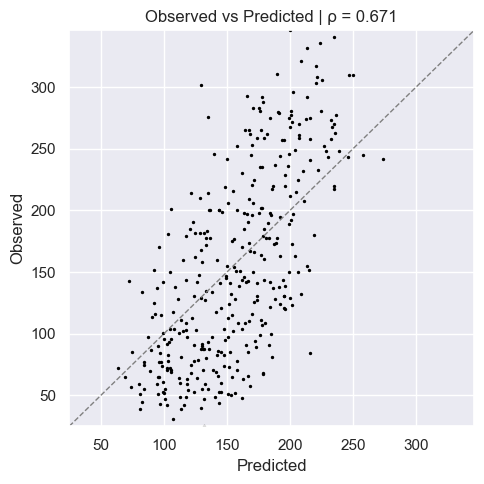

In [17]:
ml_report.model_report('MLPR').train_report().plot_obs_vs_pred()

View MLPR fit on test data

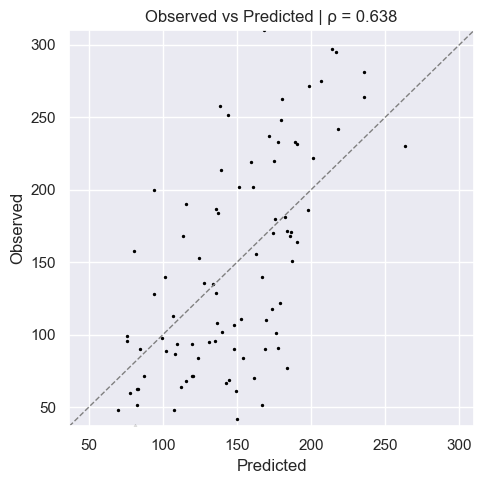

In [18]:
ml_report.model_report('MLPR').test_report().plot_obs_vs_pred()